<a href="https://colab.research.google.com/github/tenvinc/BT_HackNRoll/blob/master/CS4278_5478_Visual_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Learning to Recognize Places from Images**

The robot's goal is to reach a specified place or fetch an object. How can we specify the place? How can a robot recognize the place, i.e., the destination? We aim to learn a model that recognizes places or objects seen before. For example, given images of a place, can the robot recognize the same place from a different viewpoint?

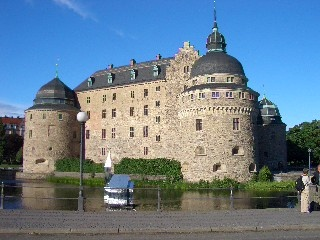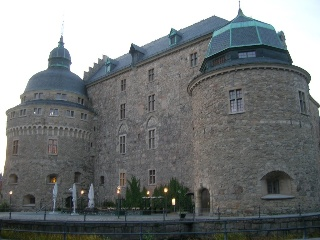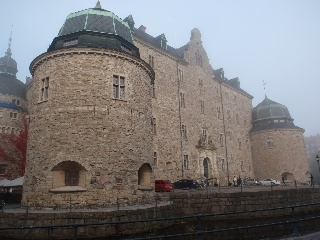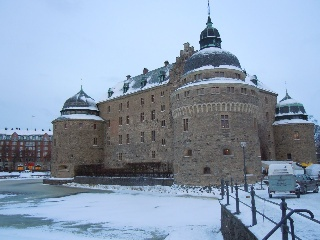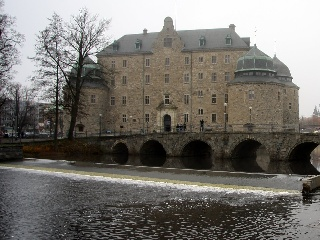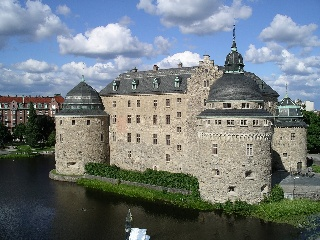


**Overview**

This Colab notebook guides you through the process of training an image classifier to recognize places, objects, ... through supervised learning. It consists of five steps, which should be executed in order.

1. *Preparation*. Check and set up the running environment: mount the google drive, create a project folder, install package dependency, ...

2. *Basic CNN Model*. Define a simple 
convolutional neural network (CNN) model that maps input images to classification scores.

3. *Data Loading*. Provide a helper class to load the data for training the agent.

4. *Basic CNN Model Training*.  Run the script provided to train a basic CNN model. 

5. *Improving Classification Performance*. Improve basic CNN model to achieve better performance for image classification.



*Remarks*
* Colab is straightforward. However, if it is new to you, it may be worthwhile to go over the introductory materials available on the [Colab home page](https://colab.research.google.com/notebooks/intro.ipynb).

* The five steps should be executed **in order**, unless you are familiar with Colab and know what you are doing.

* Training with GPUs is much faster than that with CPUs only:  under the Colab notebook dropdown menu,  choose `Runtime/Change runtime type/GPU`.

* Maintain good Internet connection throughout to avoid disconnecting from the Colab.

* Do not idle your computer, as Colab automatically disconnects GPUs if the idle time is too long.



### **1. Preparation**



**Check Python version.**

In [ ]:
!python -V

**Check Cuda version.**

In [ ]:
!nvcc -V

**Mount the Google drive.**

Mount your Google drive to store the dataset and the trained models.
Execute the cell below. Visit this [URL](https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code) to retrieve the authorization code and  enter the code at the prompt. 

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

**Create a project directory**

In [ ]:
from os import path, chdir, getcwd, mkdir

# Choose a project name
projectName = "SceneRecognition"

# Project directory is in My Drive
projectDirectory = "/content/drive/My Drive/" + projectName

# Checks if cwd is in content folder
if getcwd() == "/content":
  # Makes project directory if it does not exist
  if not path.isdir(projectDirectory):
    mkdir(projectDirectory)
    print(f"Project {projectName} has been created!")
  else:
    print(f"Project {projectName} already exist!")
  # Changes to project directory
  chdir(projectDirectory)

print(f"The current working directory is {getcwd()}")

**Install dependencies.**

In [ ]:
pip install torch torchvision

In [ ]:
pip install opencv-python

**Check GPU usage.**

In [ ]:
# Check if runtime uses GPU
import torch

gpu_name = torch.cuda.get_device_name(0)
print("Using GPU", gpu_name)

**Download the data set to your Google drive.**

The dataset requires about 700MB space. Please prepares sufficient space for downloading.

In [ ]:
from os import path, chdir, getcwd, mkdir
projectDirectory = "/content/drive/My Drive/SceneRecognition"
chdir(projectDirectory)

!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1cEwFq4reck3Fu8eAOX2_cFVyDednFui1' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1cEwFq4reck3Fu8eAOX2_cFVyDednFui1" -O data.zip 

**Unzip the dataset**

It may take few minutes to finish.

In [ ]:
!unzip data.zip


**Remove the data.zip file to save space**

In [ ]:
projectDirectory = "/content/drive/My Drive/SceneRecognition"
chdir(projectDirectory)
!rm data.zip # to save spacee NVIDIA® Tesla® K80 Accelerator dramatically lowers data center costs by delivering exceptional performance with fewer, more powerful servers. It's engineered to boost throughput in real-world applications by 5-10x, while also saving customers up to 50% for an accelerated data center compared to a CPU-only 

### **2. Basic CNN Model**

**Define the convolutional neural network (CNN) model for the image classification.**

<!-- In the earliner lecture, we talked about linear regression: fit input-output data pairs to a linear function.  -->
A linear function is not sufficient to capture the complex relationship between  input *images* and output classification labels.   Instead, we use a neural network, which is capable of representing complex nonlinear functions. The neural network model consists of several convolution layers to extract featurs from  the images and full connnected layers to map image features to the final output.

Below defines a simple CNN model for demonstration.




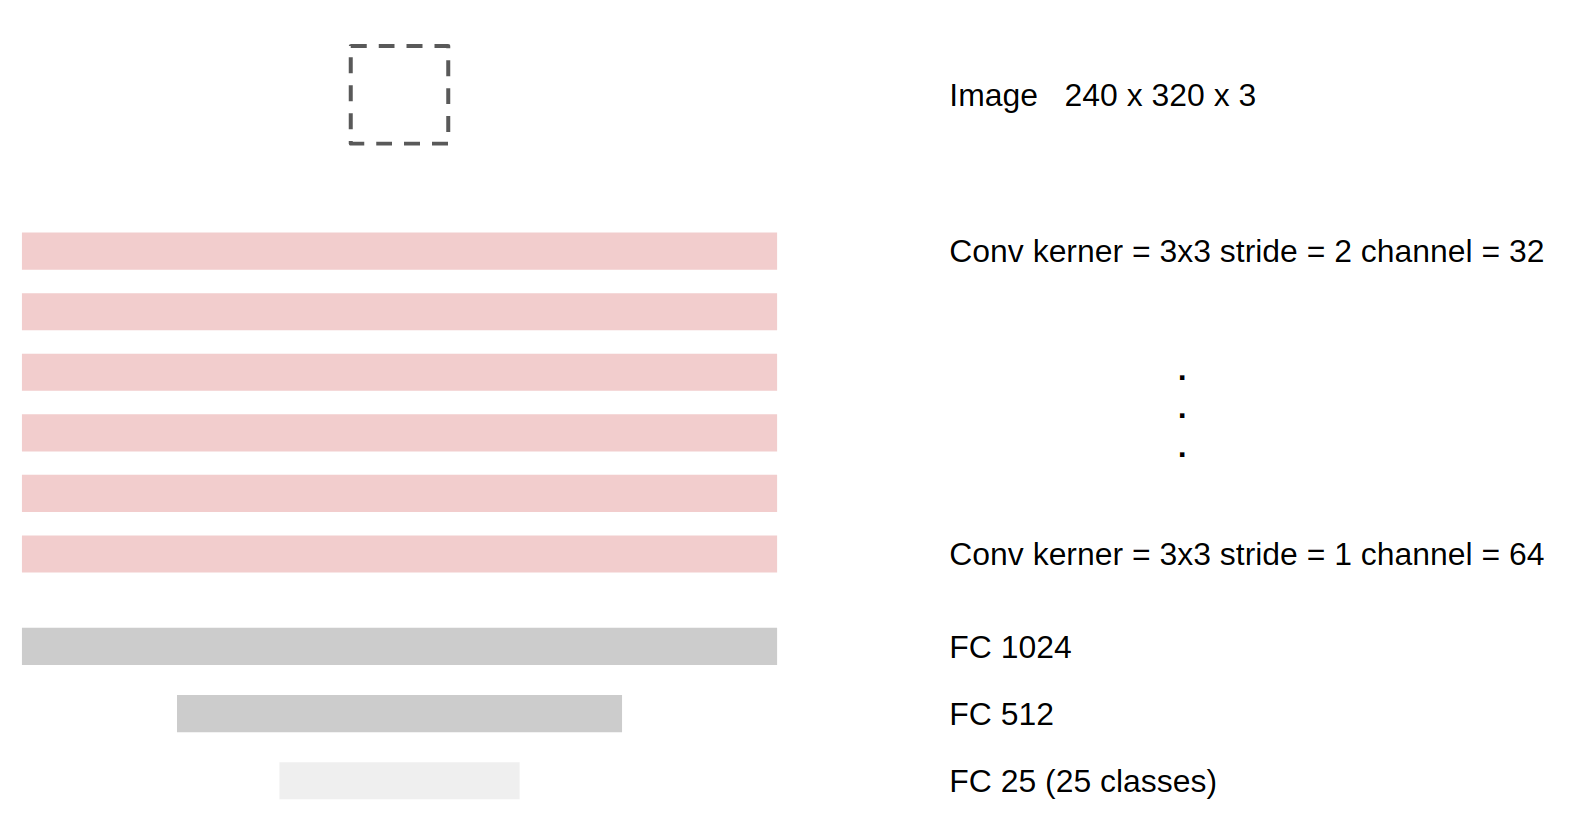

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)


class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2), nn.ReLU(),
            nn.Conv2d(32, 32, 3, stride=2), nn.ReLU(),
            nn.Conv2d(32, 32, 3, stride=2), nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2), nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=2), nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=1), nn.ReLU(),
            Flatten())

        self.fc = nn.Sequential(
            nn.Linear(1792, 1024), nn.ReLU(),
            nn.Linear(1024, 512), nn.ReLU(),
            nn.Linear(512, 25))

    def forward(self, inputs):
        output = self.cnn(inputs)
        output = self.fc(output)
        scores = F.log_softmax(output, dim=-1)

        return scores


**Load the data for training.**

The dataset consists of 25 scenes with 450 images per each.

### **3. Data Loading**

In [ ]:
import os
import cv2
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms


class MyDataset(Dataset):

    def __init__(self, is_train=True, num_cat=200):
        self.num_cat = num_cat
        self.is_train = is_train
        self.data_path = "train"
        self._load_file_list()

    def __len__(self):
        return len(self.labels)

    def _load_file_list(self):
        image_files = []
        labels = []

        work_folders = [int(f) for f in os.listdir(self.data_path) if os.path.isdir(os.path.join(self.data_path, f))]
        work_folders.sort()
        work_folders = work_folders[:self.num_cat]
        for cat in work_folders:
            cat = str(cat)
            cat_folder = os.path.join(self.data_path, cat)
            images = [f for f in os.listdir(cat_folder) if os.path.isfile(os.path.join(cat_folder, f))]
            images = images[:-50] if self.is_train else images[-50:]

            for img in images:
                img_file = os.path.join(cat_folder, img)
                image_files.append(img_file)
                labels.append(cat)

        self.image_files = image_files
        self.labels = labels

    def __getitem__(self, idx):
        img = cv2.imread(self.image_files[idx])
        if img is None:
            return self.__getitem__((idx + 1) % self.__len__())

        img = Image.open(self.image_files[idx])
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])

        img_transforms = transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ])
        img = img_transforms(img)
        label = int(self.labels[idx])

        sample = {
            'img': img,
            'label': label
        }

        return sample


### **4. Basic CNN Model Training**



**Set the working directory.**

In [ ]:
from os import path, chdir, getcwd, mkdir
projectDirectory = "/content/drive/My Drive/SceneRecognition"
chdir(projectDirectory)

**Start training.**

The first epoche is slow. With data caching, from the 2nd epoch it trains much faster.



In [ ]:
import torch
import multiprocessing as mp
from torch.optim.lr_scheduler import ReduceLROnPlateau
# from dataset import MyDataset
# from model import MyModel


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def train():
    my_model = MyModel()
    my_model = my_model.cuda().float()
    batch_size = 32
    num_epoch = 10
    num_classes = 25
    # if os.path.exists('my_model.pt'):
    #     bc_model.load_state_dict(torch.load('my_model.pt'))

    train_set = MyDataset(is_train=True, num_cat=num_classes)
    validation_set = MyDataset(is_train=False, num_cat=num_classes)


    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, pin_memory=True)
    validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=True, pin_memory=True)
    # mp.set_start_method('spawn', force=True)
    # train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4,pin_memory=True)
    # validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=True, num_workers=4,pin_memory=True)

    optimizer = torch.optim.Adam(my_model.parameters(), lr=8e-4)
    loss_func = torch.nn.NLLLoss()
    scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=500,
                                  threshold=2e-1, verbose=True, min_lr=1e-5)

    print("start training")
    for epoch in range(num_epoch):
        total = 0
        correct = 0
        my_model.train()
        for i, data in enumerate(train_loader, 0):
            optimizer.zero_grad()
            labels = data['label'].cuda()
            img = data['img'].cuda().float()
            prediction = my_model(img)

            loss = loss_func(prediction, labels)
            loss.backward()
            optimizer.step()
            scheduler.step(loss)

            _, predicted = torch.max(prediction, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            print('[epoch: %5d/%5d, batch: %5d] loss: %.3f, lr: %.10f, acc %d %%'
                  % (epoch, num_epoch, i, loss.clone().item(), get_lr(optimizer), (100 * correct / total)))

        # validation accuracy
        total = 0
        correct = 0
        my_model.eval()
        for i, data in enumerate(validation_loader, 0):
            labels = data['label'].cuda()
            img = data['img'].cuda().float()
            prediction = my_model(img)

            _, predicted = torch.max(prediction, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('[epoch: %5d/%5d] validation acc %d %%'
              % (epoch, num_epoch, (100 * correct / total)))

        torch.save(my_model.state_dict(), "my_model.pt")


if __name__ == "__main__":
    train()


### **5. Improve  Classification Performance**

The basic CNN model works poorly on the training data, and  achieves about 57% classification accuracy over 25 classes after 10 epochs on the validation dataset. Now your task is to investigate why the basic CNN model does not perform well and improve the classifier to achieve higher classification accuracy. Some specific suggestions are given below.

**1\. Augment the data**. The augmentation technique artificially expands the size of a training dataset by creating modified versions of images. It creates variations of the images that can improve the  model' ability to generalize. You can easily follow this [Github project](https://github.com/aleju/imgaug) to create your image augmented dataset and implement it in the data loading step. 

Below are examples of augmented images.

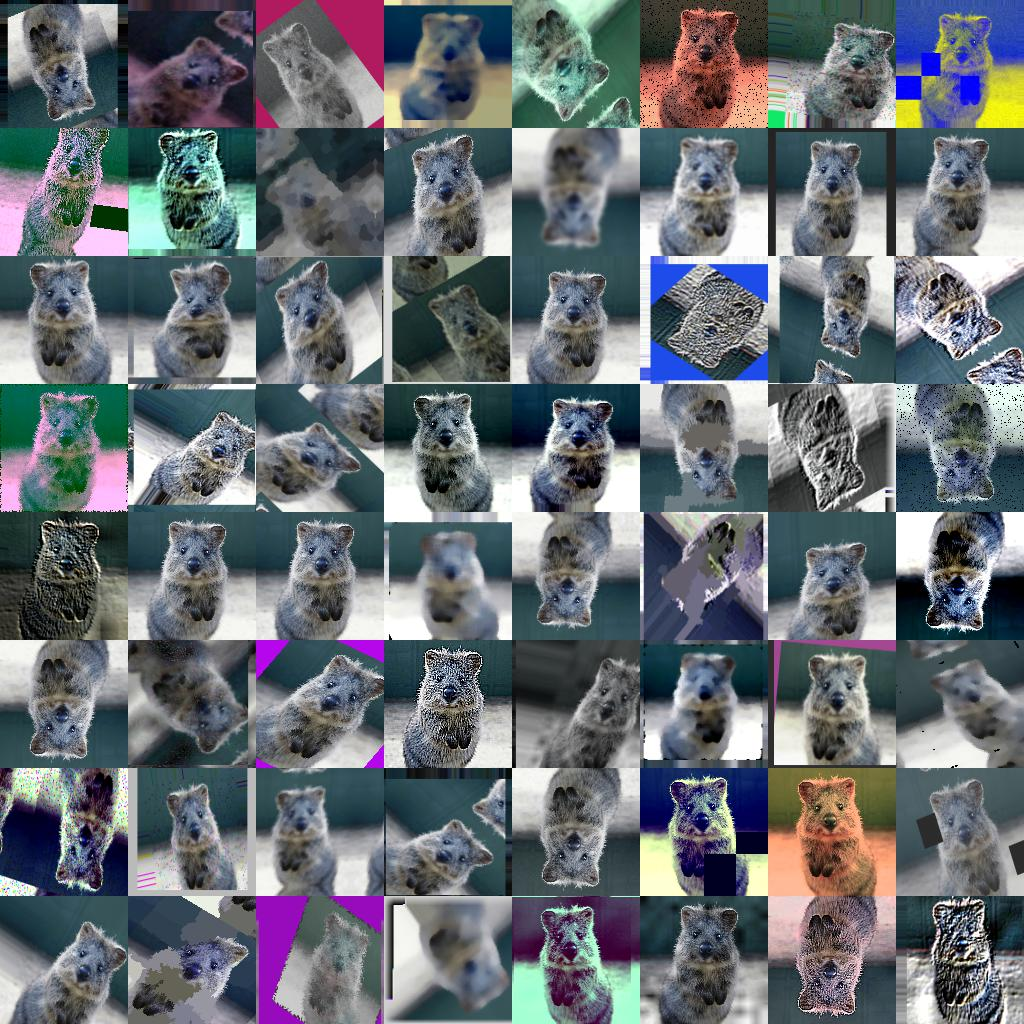

**2. Improve  feature extraction.** A good image feature extractor is key to good performance. There are many choices, including the popular ones,  ResNet and MobileNet. Most of them are simple to use. 

* ResNet and other pretrained models: https://github.com/Cadene/pretrained-models.pytorch
* A PyTorch implementation of MobileNetV2: https://github.com/tonylins/pytorch-mobilenet-v2

The key idea is to use a powerful feature extractor to replace the basic feature extractor `self.cnn` in the Basic CNN Model step. After that, we can fine-tune our own decision network, a few fully connected layers, to classify the image.










**3. Tune the learning algorithm.**  Hyperparameter tuning is important to neural network training. Try to adjust the following parameters in section 4 basic CNN model training:

- learning rate
- batch size
- number of epochs
- optimizers


*Remarks*

You  can set the number of classes to a small number (e.g., 3), when tuning the hyperparameters. The training then becomes much faster. However, remember to set it back when training your final model.


# **Submission**



Create a single zip file `YourMatricNumber.zip` (e.g., `A01234567.zip` ) containg the following:

1. Colab notebook
 * Download your entire Colab notebook. Save it as an ipynb file and name it `YourMatricNumber-Notebook.ipynb`.
2. Neural network model class
  
  This file will be used to load your pretrained model and hence for evaluation.
 * Name the file  `Model.py`
 * See example code in  Section 4 Basic CNN Model above.
 * Do not change the inner class name and keep it as "MyModel".

3. Pretrained model
    - Name the file as `YourMatricNumber-Model.pt`
    - You can find the example code to save your model in Section 4 Basic CNN Model Training

    


Your pre-trained model will be evaluated  on a set of unseen test images for classification accuracy. Make sure your pretrained model is **reproducible** from your Colab notebook.

Below is the test script for  evaluation. You may use it to check your model's performance. Of course, a different test image set will be used for the actual evaluation.

In [ ]:
projectDirectory = "/content/drive/My Drive/SceneRecognition"
chdir(projectDirectory)

In [ ]:
import torch

def test():
    my_model = MyModel()
    my_model = my_model.cuda().float()
    batch_size = 32

    my_model.load_state_dict(torch.load('my_model.pt'))
    validation_set = MyDataset(is_train=False, num_cat=25)

    # mp.set_start_method('spawn', force=True)
    validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=True)

    # validation accuracy
    total = 0
    correct = 0
    for i, data in enumerate(validation_loader, 0):
        labels = data['label'].cuda()
        img = data['img'].cuda().float()
        prediction = my_model(img)

        _, predicted = torch.max(prediction, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        print('[batch: %5d], acc %d %%'
              % ( i, (100 * correct / total)))

    print('validation acc %d %%' % (100 * correct / total))


if __name__ == "__main__":
    test()
